# 1. Постановка задачи - одномерный гармонический осцилятор


<img src="oscillator.gif" width="500">

Мы хотим смоделировать смещение $u(t)$ осциллятора как функцию времени, что сводится к решению одномерного обыкновенного дифференциального уравнения:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

где $m$ масса, $\mu$ коэффициент трения и $k$ жесткость пружины.

Рассмотрим случай, при котором колебания медленно затухают:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

**Начальные условия** системы:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Для данного ОДУ знаем **точное решение**:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


# Как (FB)PINNs решают эту задачу?


PINNs используют нейронную сеть с обучаемыми параметрами $\\theta$ для **прямого аппроксимирования** решения дифференциального уравнения, т.е.

$$
N\!N(t;\theta) \approx u(t)~,
$$

Затем, чтобы обучить сеть на решение задачи, используется следующая **функция потерь**:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
$$


Первые два члена известны как **граничные потери** (**boundary loss**), которые пытаются обеспечить соблюдение граничных условий, а последний член известен как **физические потери** (**physics loss**), которые минимизируют остаток дифференциального уравнения по всей области задачи. $\\{t_{i}\\}_{i=1}^N$ — набор координат, выбранных по всей области задачи, используемых для вычисления физических потерь, а $\\lambda_1$ и $\\lambda_2$ — скалярные гиперпараметры, используемые для управления балансом между различными членами в функции потерь.


# Как это работает?

<img src="topic_pic.png" width="500">

Для использования FBPINN необходимо:

1. Определить **область определения задачи** (**problem domain**), используя класс `fbpinns.domains.RectangularDomainND`;
2. Задать **ОДУ** для решения и его **ограничения задачи** (**problem constraints**), определив наш собственный класс `fbpinns.problems.Problem`;
3.  Задать **разбиение области** (**domain decomposition**), используемое FBPINN, с помощью класса `fbpinns.decompositions.RectangularDecompositionND`;
4. Задать **нейронную сеть**, размещенную в каждой подобласти, с помощью класса `fbpinns.networks.FCN`;
5. Передать эти классы и их значения инициализации объекту `fbpinns.constants.Constants`;
6. Начать обучение FBPINN, создав экземпляр `fbpinns.trainer.FBPINNTrainer` с использованием объекта `Constants`.

## Шаг 1: Область определения задачи

In [60]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND 
domain_init_kwargs = dict(
    xmin=np.array([0.,]),
    xmax=np.array([1.,]),# задание области  [0, 1]
)

## Шаг 2: Определение ОДУ для решения

Next, we will define our own `fbpinns.problems.Problem` class to define the ODE to solve. The important things we must define in this class are:

1. **Ограничения задачи**: это все входные точки, любые метки для обучения с учителем, а также компоненты решения и градиентов, необходимые для вычисления каждого члена (т.е. ограничения) в функции потерь
2. **Функция потерь**, используемая для обучения FBPINN, с учетом этих ограничений
3. **Точное решение**, если оно существует, используемое для тестирования FBPINN во время обучения


### Наследование класса `Problem`

Все классы задач должны наследоваться от базового класса `fbpinns.problems.Problem`!
import jax.numpy as jnp
from fbpinns.problems import Problem

The base `Problem` class is shown below:

```python
class Problem:
    """Базовый класс задачи, который наследуется разными классами задач.

    Все методы класса должны быть написаны так, чтобы не иметь побочных эффектов — то есть они не должны изменять внешнее состояние (например, глобальные переменные или входные данные). Это требование JAX для корректной работы jit (just-in-time компиляции) и автоматического дифференцирования.
    """

    @staticmethod # Гарантирует, что метод не будет изменять внутреннее состояние класса
    def init_params(*args):
        """Инициализация параметров класса.
        Возвращает кортеж из словарей ({k: pytree}, {k: pytree}), содержащих статические и обучаемые параметры"""

        static_params = {
            "dims":None,# в виде (ud, xd) # размерность u и x
            # и тд
            }
        raise NotImplementedError

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        """Samples all constraints.
        Возвращает [[x_batch, *любые_ограничивающие_значения, required_ujs], ...]. Каждый элемент списка содержит\n",
    "        точки x_batch и любые ограничивающие значения, передаваемые в функцию потерь, а также требуемые\n",
    "        компоненты решения и градиента, необходимые в функции потерь для каждого ограничения."""
        raise NotImplementedError

    @staticmethod
    def loss_fn(all_params, constraints):
        """Вычисляет функцию потерь PINN, используя ограничения с той же структурой, что и на выходе sample_constraints"""
        raise NotImplementedError

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """Определяет точное решение, если оно существует"""
        raise NotImplementedError
```

```python
@staticmethod
def init_params(d=2, w0=20): # m = 1

    mu, k = 2*d, w0**2

    static_params = {
        "dims":(1,1),
        "d":d,
        "w0":w0,
        "mu":mu,
        "k":k,
        }

    return static_params, {}
```

### `Problem.sample_constraints(all_params, domain, key, sampler, batch_shapes)`

Метод `sample_constraints` должен возвращать все входные точки, любые метки для обучения с учителем, а также компоненты решения и градиентов, необходимые для вычисления каждого члена (т.е. ограничения) в функции потерь.

Он должен возвращать список `constraints`, где каждый элемент списка содержит величины, необходимые для каждого члена в функции потерь.

#### Определение каждого ограничения задачи

Для нашей задачи у нас есть два члена (т.е. ограничения) — граничные потери и физические потери.

Для **граничных потерь** нам нужна только одна входная точка ($t=0$). Нам также нужны две метки для обучения с учителем ($u(0)=1$ и $u_t(0)=0$), которые определяют начальное положение и скорость осциллятора. 

Мы указываем входные точки и метки, используя `jnp.array`. Массив входных точек должен иметь размерность `(n,xd)`, где `n` — количество входных точек, а `xd` — размерность входных точек, и любые массивы меток должны иметь размерность `(n,ld)`, где `n` — количество входных точек, а `ld` — размерность каждой метки.

Для вычисления граничных потерь нам нужно как решение FBPINN ($u$), так и его производная первого порядка ($u_t$). Мы указываем требуемые компоненты решения и градиентов, используя кортежи, где первое значение кортежа обозначает индекс компонента решения, а следующий кортеж указывает индексы любых координат, по которым нам нужны градиенты (например, `(0,())` означает, что нам нужно $u$, а `(0,(0,))` означает, что нам нужно $u_{t}$ для нашей задачи)..

Для **физических потерь** мы выбираем входные точки по всей области (используя вспомогательную функцию `sample_interior` класса `fbpinns.domains.Domain`, переданного методу). Нам не нужны никакие метки для обучения с учителем для физических потерь, и нам нужно решение FBPINN, а также его производные первого и второго порядка.
Количество входных точек для каждого ограничения можно взять из аргумента `batch_shapes` (`fbpinns.constants.Constants.ns` передается как `batch_shapes` во время обучения), а `key` — это случайный ключ `jax`.

```python
@staticmethod
def sample_constraints(all_params, domain, key, sampler, batch_shapes):

    # physics loss
    x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
    required_ujs_phys = (
        (0,()), # функция u
        (0,(0,)), # u_t
        (0,(0,0)) # u_t_t
    )

    # boundary loss
    x_batch_boundary = jnp.array([0.]).reshape((1,1))
    u_boundary = jnp.array([1.]).reshape((1,1)) # условие на u
    ut_boundary = jnp.array([0.]).reshape((1,1)) # условие на u_t
    required_ujs_boundary = (
        (0,()),
        (0,(0,)),
    )

    return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, u_boundary, ut_boundary, required_ujs_boundary]]
```

### `loss_fn(all_params, constraints)`

Метод `loss_fn` вычисляет функцию потерь FBPINN, учитывая `constraints`, определенные `sample_constraints`.

Аргумент `constraints`, переданный этой функции, имеет точно такую же структуру, как и список `constraints`, выведенный `sample_constraints`, с двумя исключениями:
кортежи `required_ujs` заменяются `jnp.array`, содержащими фактические вычисленные градиенты FBPINN

```python
@staticmethod
def loss_fn(all_params, constraints):

    mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

    # physics loss
    _, u, ut, utt = constraints[0]
    phys = jnp.mean((utt + mu*ut + k*u)**2)

    # boundary loss
    _, uc, utc, u, ut = constraints[1]
    boundary = 1e6*jnp.mean((u-uc)**2) + 1e2*jnp.mean((ut-utc)**2)

    return phys + boundary
```

### `Problem.exact_solution(all_params, x_batch, batch_shape=None)`

Метод `exact_solution` вычисляет точное решение задачи, если оно существует, которое используется для тестирования FBPINN во время обучения.

Входом для этой функции является пакет входных точек (`x_batch`), содержащийся в `jnp.array` формы `(n, xd)`. Выходом функции должно быть решение, вычисленное в этих точках, содержащееся в `jnp.array` формы `(n, ud)`. 

```python
@staticmethod
def exact_solution(all_params, x_batch, batch_shape=None):

    d, w0 = all_params["static"]["problem"]["d"], all_params["static"]["problem"]["w0"]

    w = jnp.sqrt(w0**2-d**2)
    phi = jnp.arctan(-d/w)
    A = 1/(2*jnp.cos(phi))
    cos = jnp.cos(phi + w * x_batch)
    exp = jnp.exp(-d * x_batch)
    u = exp * 2 * A * cos

    return u
```

Полностью определенный класс `Problem` и его начальные значения приведены ниже:

In [73]:
class HarmonicOscillator1D(Problem):
    """
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20): # m = 1

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1), # ud, xd
            "d":d,
            "w0":w0,
            "mu":mu,
            "k":k,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()), # u
            (0,(0,)), # u_t
            (0,(0,0)) # u_t_t
        )

        # boundary loss
        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        u_boundary = jnp.array([1.]).reshape((1,1)) # условие на u
        ut_boundary = jnp.array([0.]).reshape((1,1)) # условие на u_t
        required_ujs_boundary = (
            (0,()),  # u
            (0,(0,)), # u_t
        )

        return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, u_boundary, ut_boundary, required_ujs_boundary]]

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        # physics loss
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        # boundary loss
        _, uc, utc, u, ut = constraints[1]
        boundary = 1e6*jnp.mean((u-uc)**2) + 1e2*jnp.mean((ut-utc)**2)

        return phys + boundary

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):

        d, w0 = all_params["static"]["problem"]["d"], all_params["static"]["problem"]["w0"]

        w = jnp.sqrt(w0**2-d**2)
        phi = jnp.arctan(-d/w)
        A = 1/(2*jnp.cos(phi))
        cos = jnp.cos(phi + w * x_batch)
        exp = jnp.exp(-d * x_batch)
        u = exp * 2 * A * cos

        return u
    
problem = HarmonicOscillator1D
problem_init_kwargs=dict(
    d=2, w0=80,# определение параметров ОДУ
)

## Шаг 3: Определение разбиения области

Для этого примера мы будем использовать существующий класс `fbpinns.decompositions.RectangularDecompositionND` для определения разбиения области. Снова, все, что нам нужно сделать, это определить значения инициализации этого класса:

In [74]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND # используем регулярную прямоугольную сетку
decomposition_init_kwargs=dict(
    subdomain_xs=[np.linspace(0,1,15)],# 15 ячеек
    subdomain_ws=[0.15*np.ones((15,))],# ширина ячеек 0.15
    unnorm=(0.,1.),# определяет нормализацию сетей подобласти
)

## Шаг 4: Определение нейронной сети

Для этого примера мы будем использовать существующий класс `fbpinns.networks.FCN` для определения нейронной сети, размещенной в каждой подобласти. Снова, все, что нам нужно сделать, это определить значения инициализации этого класса:

In [75]:
from fbpinns.networks import FCN

network = FCN # в каждой ячейке полносвязная нейронная сеть
network_init_kwargs=dict(
    layer_sizes=[1,32,1],
)

## Шаг 5: Определение констант

In [76]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# точек для обучения
    n_test=(500,),# точек для тестирования
    n_steps=20000,# шагов обучения
    clear_output=True,
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0]), 'xmax': array([0.5])}
problem: <class '__main__.HarmonicOscillator1D'>
problem_init_kwargs: {'d': 2, 'w0': 80}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])], 'subdomain_ws': [array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x000002760EA99E40>
optimiser_kwargs: {'learning_rate': 

## Шаг 6: Обучение FBPINN

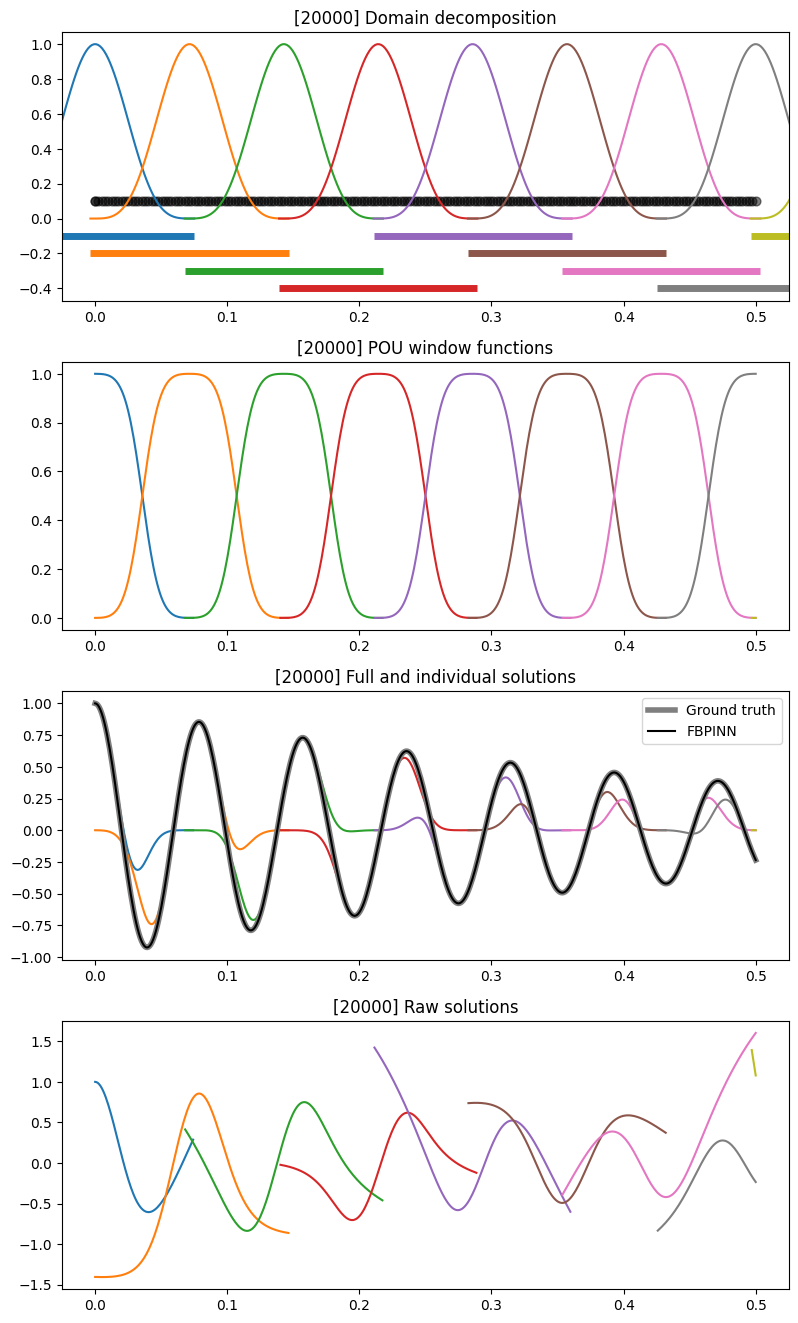

[INFO] 2025-04-18 13:45:16 - [i: 20000/20000] Training complete


In [77]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()

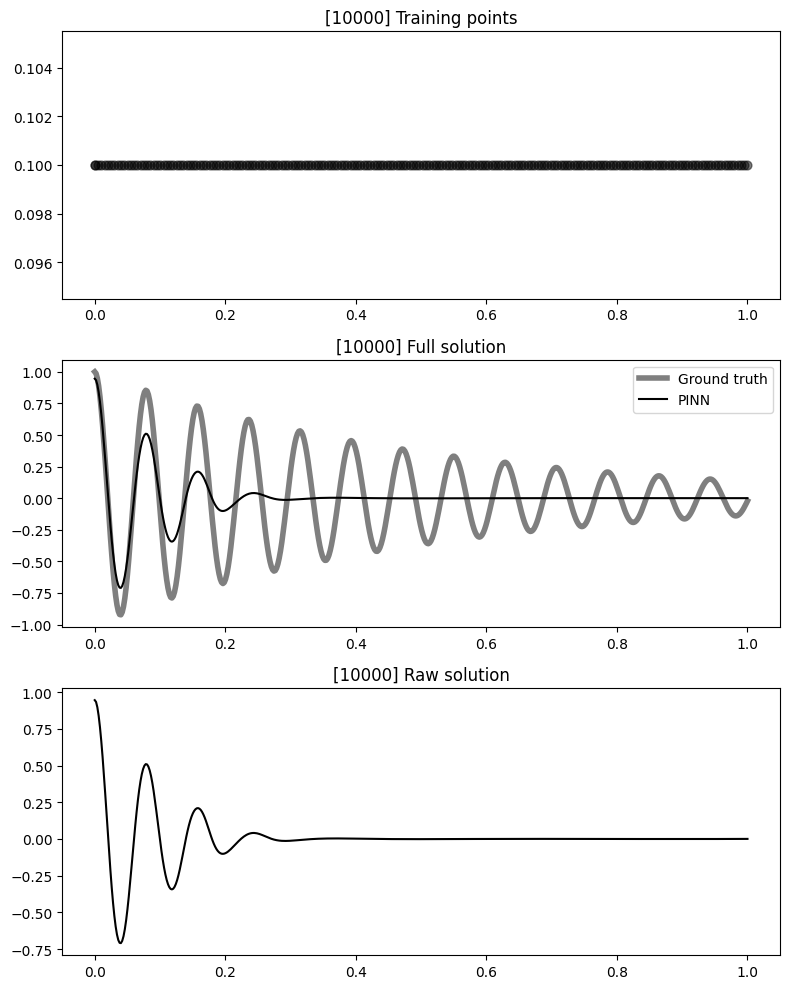

[INFO] 2025-04-18 13:44:10 - [i: 10000/10000] Training complete


{'static': {'domain': {'xd': 1,
   'xmin': Array([0.], dtype=float32),
   'xmax': Array([1.], dtype=float32)},
  'problem': {'dims': (1, 1), 'd': 2, 'w0': 80, 'mu': 4, 'k': 6400}},
 'trainable': {'network': {'subdomain': {'layers': [(Array([[ 0.6867289 ],
             [-0.5980759 ],
             [-0.39390454],
             [-0.9529417 ],
             [-1.2965553 ],
             [-0.99242866],
             [ 1.1488373 ],
             [ 1.1606233 ],
             [ 1.058911  ],
             [ 1.7186389 ],
             [-0.93242437],
             [ 0.42209926],
             [-1.6811974 ],
             [-0.8306723 ],
             [-0.21464042],
             [-0.0643456 ],
             [ 0.51366836],
             [ 0.32172695],
             [-1.4692554 ],
             [-0.7452849 ],
             [ 1.2165492 ],
             [ 1.2170436 ],
             [-0.8932064 ],
             [ 0.74042296],
             [ 0.72102064],
             [ 0.99700177],
             [ 1.2666416 ],
             [ 1

In [66]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[1,64,64,1])# use a larger neural network
c["n_steps"] = 10000 # use a larger neural network
run = PINNTrainer(c)
run.train()# start training a PINN on the same problem

## Пример постановки задачи

In [78]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND 
domain_init_kwargs = dict(
    xmin=np.array([0,]),
    xmax=np.array([0.5,]),
)

In [80]:
import jax.numpy as jnp
from fbpinns.problems import Problem

class HarmonicOscillator1D(Problem):
    """
          d^3 y   d^2 y
          ----- - ---- - 3x^2 + 5 = 0
          dx^3    dx^2

        y  (0) = 0
        y' (0) = 3
        y''(0) = 2

        Точное решение:
        y = -2 + x + 2*exp(x) - 0.25*x^4 - x^3 - 0.5*x^2
    """

    @staticmethod
    def init_params(): 

        static_params = {
            "dims":(1,1), # yd, xd
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)), # y_x_x
            (0,(0,0,0)) # y_x_x_x
        )

        # boundary loss
        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        y_boundary = jnp.array([0.]).reshape((1,1)) # условие на y
        yx_boundary = jnp.array([3.]).reshape((1,1)) # условие на y_x
        yxx_boundary = jnp.array([2.]).reshape((1,1)) # условие на y_x_x
        required_ujs_boundary = (
            (0,()),  # y
            (0,(0,)), # y_x
            (0,(0,0)) # y_x_x
        )

        return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, y_boundary, yx_boundary, yxx_boundary, required_ujs_boundary]]

    @staticmethod
    def loss_fn(all_params, constraints):
        # physics loss
        x, yxx, yxxx = constraints[0]
        phys = jnp.mean((yxxx - yxx - 3*x*x + 5)**2)

        # boundary loss
        _, yc, yxc, yxxc, y, yx, yxx = constraints[1]
        boundary = 1e6*jnp.mean((y-yc)**2) + 1e3*jnp.mean((yx-yxc)**2) + 1e6*jnp.mean((yxx-yxxc)**2)

        return phys + boundary

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        return -2 + x_batch + 2*jnp.exp(x_batch) - 0.25*x_batch**4 - x_batch**3 - 0.5*x_batch**2
    
problem = HarmonicOscillator1D
problem_init_kwargs=dict()


In [84]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND # используем регулярную прямоугольную сетку
decomposition_init_kwargs=dict(
    subdomain_xs=[np.linspace(0,0.5,3)],
    subdomain_ws=[0.8*np.ones((3,))],
    unnorm=(0.,1.),# определяет нормализацию сетей подобласти
)

In [85]:
from fbpinns.networks import FCN

network = FCN # в каждой ячейке полносвязная нейронная сеть
network_init_kwargs=dict(
    layer_sizes=[1,32,1],
)

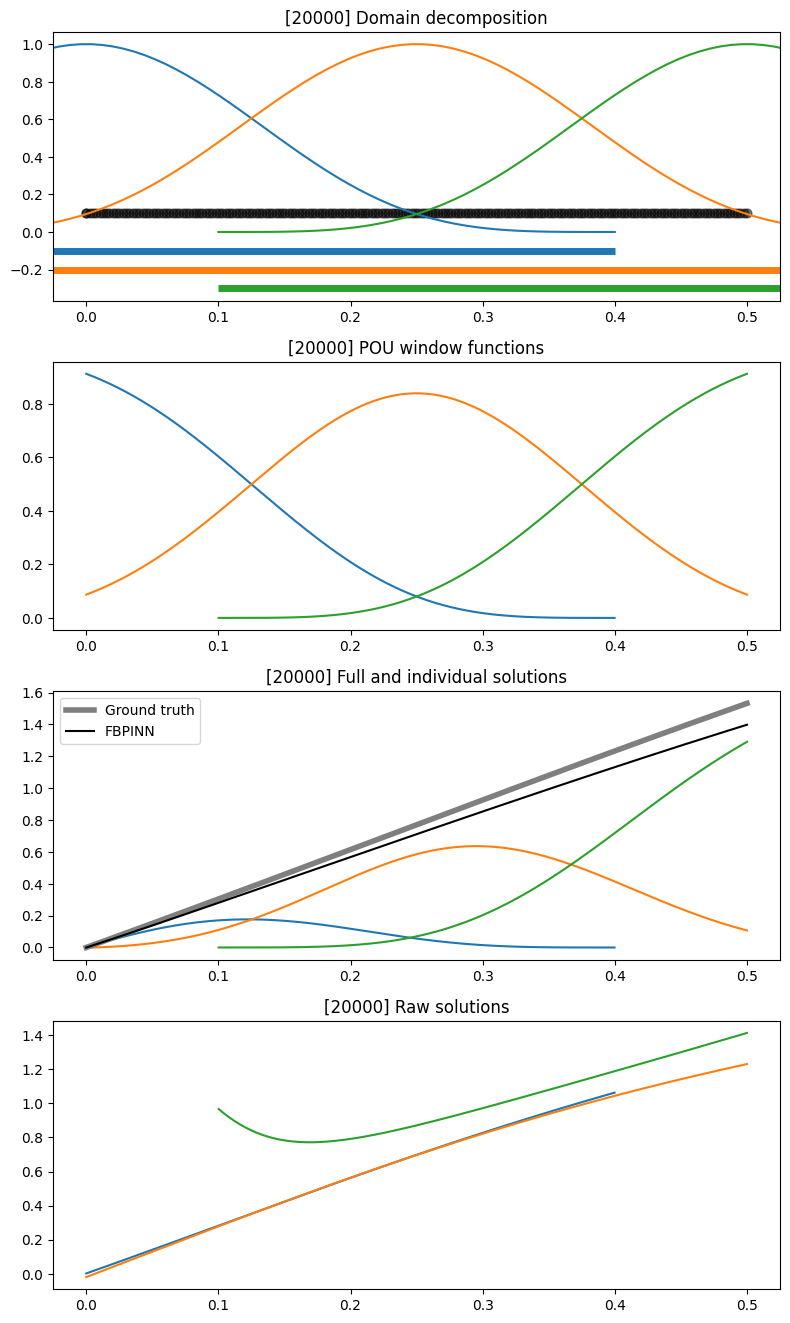

[INFO] 2025-04-18 13:49:06 - [i: 20000/20000] Training complete


In [86]:
from fbpinns.trainers import FBPINNTrainer
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# точек для обучения
    n_test=(500,),# точек для тестирования
    n_steps=20000,# шагов обучения
    clear_output=True,
)
run = FBPINNTrainer(c)
all_params = run.train()

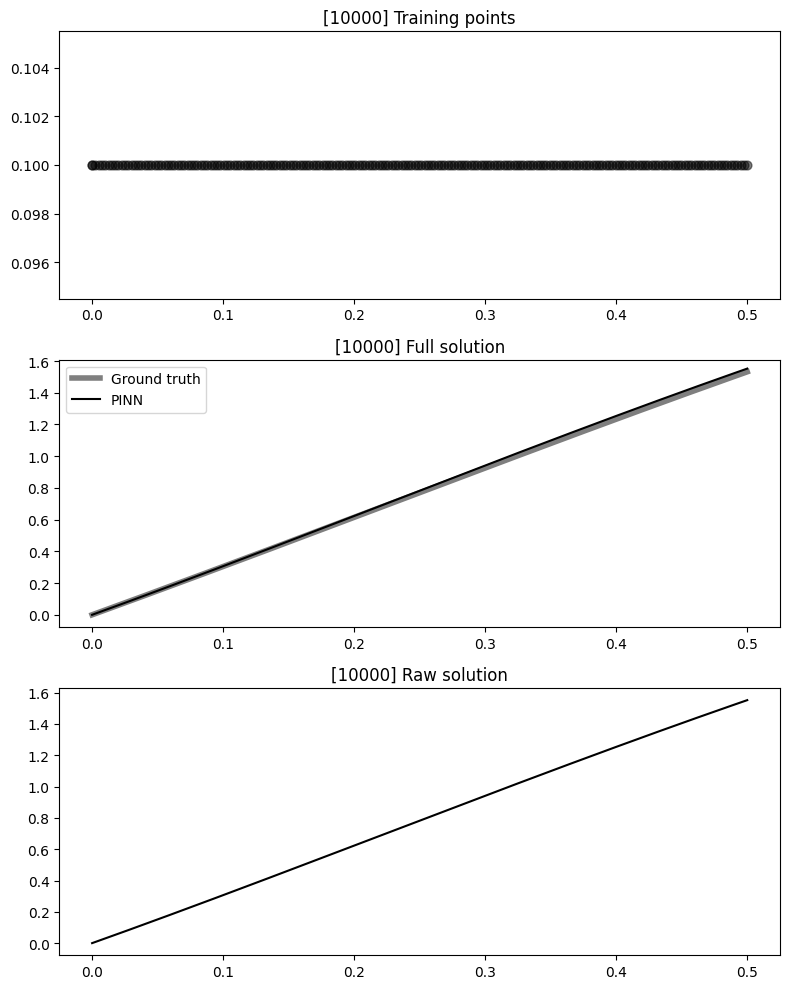

[INFO] 2025-04-18 13:49:49 - [i: 10000/10000] Training complete


{'static': {'domain': {'xd': 1,
   'xmin': Array([0], dtype=int32),
   'xmax': Array([0.5], dtype=float32)},
  'problem': {'dims': (1, 1)}},
 'trainable': {'network': {'subdomain': {'layers': [(Array([[ 0.21230292],
             [-0.20742114],
             [-0.6598945 ],
             [-0.6693381 ],
             [-0.53734386],
             [-0.23291926],
             [ 0.2938986 ],
             [-0.03782676],
             [-0.06758354],
             [ 0.15974742],
             [ 0.13554752],
             [ 0.26445767],
             [-0.7660689 ],
             [-0.7742488 ],
             [-0.24058829],
             [-0.15420252],
             [ 0.5158564 ],
             [ 0.181076  ],
             [-0.07627009],
             [-0.6658994 ],
             [ 0.07320332],
             [ 0.17704894],
             [-0.08920288],
             [ 0.19796896],
             [ 0.05819657],
             [-0.21527451],
             [ 0.46557415],
             [ 0.1054806 ],
             [-0.56496745],


In [87]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[1,64,64,1])# use a larger neural network
c["n_steps"] = 10000 # use a larger neural network
run = PINNTrainer(c)
run.train()# start training a PINN on the same problem

## Пример постановки задачи

In [95]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND 
domain_init_kwargs = dict(
    xmin=np.array([0.,]),
    xmax=np.array([1,]),
)

In [96]:
import jax.numpy as jnp
from fbpinns.problems import Problem

class HarmonicOscillator1D(Problem):
    """
          d^2 y   
          ----- + y - 5sin(2x) = 0
          dx^2    

        y  (0) = 1
        y' (0) = -7/3

        Точное решение:
        y = cos(x) + sin(x) - 5/3*sin(2x)
    """

    @staticmethod
    def init_params(): 

        static_params = {
            "dims":(1,1), # yd, xd
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()), # y
            (0,(0,0)) # y_x_x
        )

        # boundary loss
        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        y_boundary = jnp.array([1.]).reshape((1,1)) # условие на y
        yx_boundary = jnp.array([-7./3.]).reshape((1,1)) # условие на y_x
        required_ujs_boundary = (
            (0,()),  # y
            (0,(0,)), # y_x
        )

        return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, y_boundary, yx_boundary, required_ujs_boundary]]

    @staticmethod
    def loss_fn(all_params, constraints):
        # physics loss
        x, y, yxx = constraints[0]
        phys = jnp.mean((yxx + y - 5*jnp.sin(2*x))**2)

        # boundary loss
        _, yc, yxc, y, yx = constraints[1]
        boundary = 1e6*jnp.mean((y-yc)**2) + 1e2*jnp.mean((yx-yxc)**2)

        return phys + boundary

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        return jnp.cos(x_batch) + jnp.sin(x_batch) - 5/3*jnp.sin(2*x_batch)
    
problem = HarmonicOscillator1D
problem_init_kwargs=dict()

In [99]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND # используем регулярную прямоугольную сетку
decomposition_init_kwargs=dict(
    subdomain_xs=[np.linspace(0,1,15)],
    subdomain_ws=[0.15*np.ones((15,))],
    unnorm=(0.,1.),# определяет нормализацию сетей подобласти
)

In [100]:
from fbpinns.networks import FCN

network = FCN # в каждой ячейке полносвязная нейронная сеть
network_init_kwargs=dict(
    layer_sizes=[1,32,1],
)

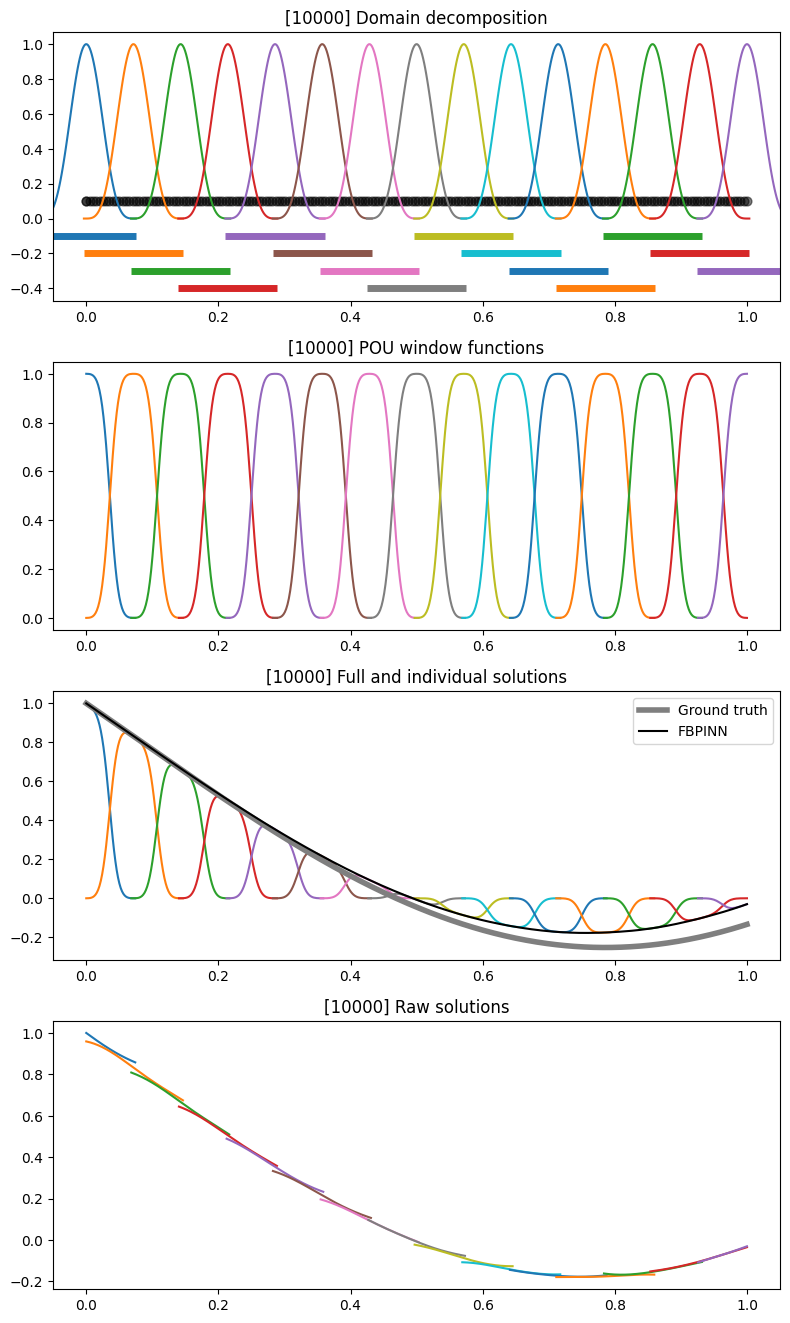

[INFO] 2025-04-18 13:52:06 - [i: 10000/10000] Training complete


In [101]:
from fbpinns.trainers import FBPINNTrainer
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# точек для обучения
    n_test=(500,),# точек для тестирования
    n_steps=10000,# шагов обучения
    clear_output=True,
)
run = FBPINNTrainer(c)
all_params = run.train()

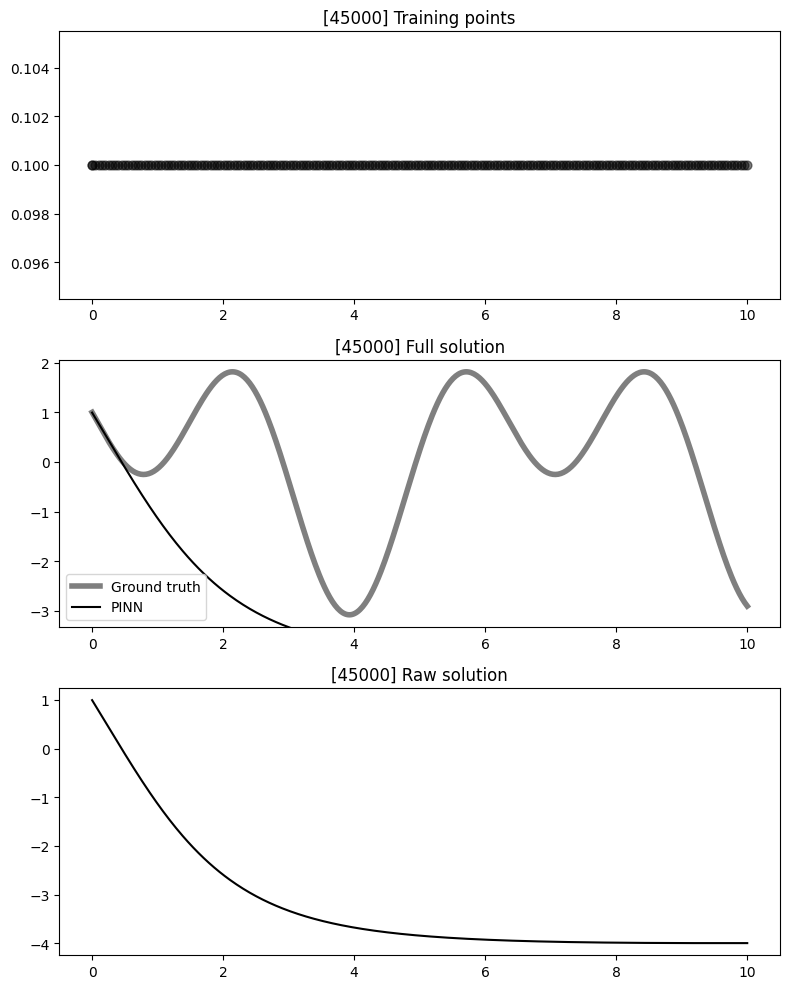

[INFO] 2025-04-18 13:51:40 - [i: 46000/100000] loss: 48.9027 rate: 728.8 elapsed: 0.02 hr test


KeyboardInterrupt: 

In [94]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[1,64,64,1])# use a larger neural network
c["n_steps"] = 100000 # use a larger neural network
run = PINNTrainer(c)
run.train()# start training a PINN on the same problem

# Жесткие ограничения (hard contrains)

Ранее для одномерного осцилятора использовали функцию потерь для обучения (FB)PINN:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
$$

При использовании этой функции потерь граничные условия задаются "мягким" образом; если два граничных условия потерь не будут полностью сведены к минимуму, (FB)PINN не будет точно соответствовать граничным условиям.

### Жесткие ограничения 
Альтернативный подход заключается в установлении граничных условий "жестким" образом. Чтобы сделать это, мы вместо этого предполагаем, что нейронная сеть является частью **решения ansatz**, $\ hat u (t;\theta)$, которое аппроксимирует решение дифференциального уравнения, и записываем

$$
\hat u (t;\theta) = \mathcal{C}[N\!N(t;\theta)] \approx u(t)~,
$$

где $\mathcal{C}$ - это некоторый **ограничивающий оператор**, применяемый к выходным данным (FB)PINN, который жестко устанавливает граничные условия путем математического построения анзаца решения.

### Жесткие ограничения для гармонического осциллятора

Для задачи, описанной выше, мы можем задать жесткие граничные условия, используя следующий оператор ограничения и аналог решения:

$$
\hat u (t;\theta) = 1 + \tanh(t/\sigma)^2 N\!N(t;\theta)
$$

Этот анзац автоматически подчиняется граничным условиям $u(0)=1$ и $u_t(0)=0$. Причем $\sigma$ - это скалярный гиперпараметр, который определяет ширину ограничивающей функции $\tanh$.

Учитывая, что граничные условия уже заданы в ansatz, граничные потери больше не требуется, и (FB)PINN с жесткими ограничениями можно обучать, используя только физические потери.

In [102]:
import jax.numpy as jnp
from fbpinns.problems import HarmonicOscillator1D

class HarmonicOscillator1DHardBC(HarmonicOscillator1D):
    """Solves the time-dependent damped harmonic oscillator using hard boundary conditions
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        Boundary conditions:
        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20, sd=0.1):

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1),
            "d":d,
            "w0":w0,
            "mu":mu,
            "k":k,
            "sd":sd,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )
        return [[x_batch_phys, required_ujs_phys],]# only physics loss required in this case

    @staticmethod
    def constraining_fn(all_params, x_batch, u):

        sd = all_params["static"]["problem"]["sd"]
        x, tanh = x_batch[:,0:1], jnp.tanh

        u = 1 + (tanh(x/sd)**2) * u# applies hard BCs
        return u

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        # physics loss
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        return phys

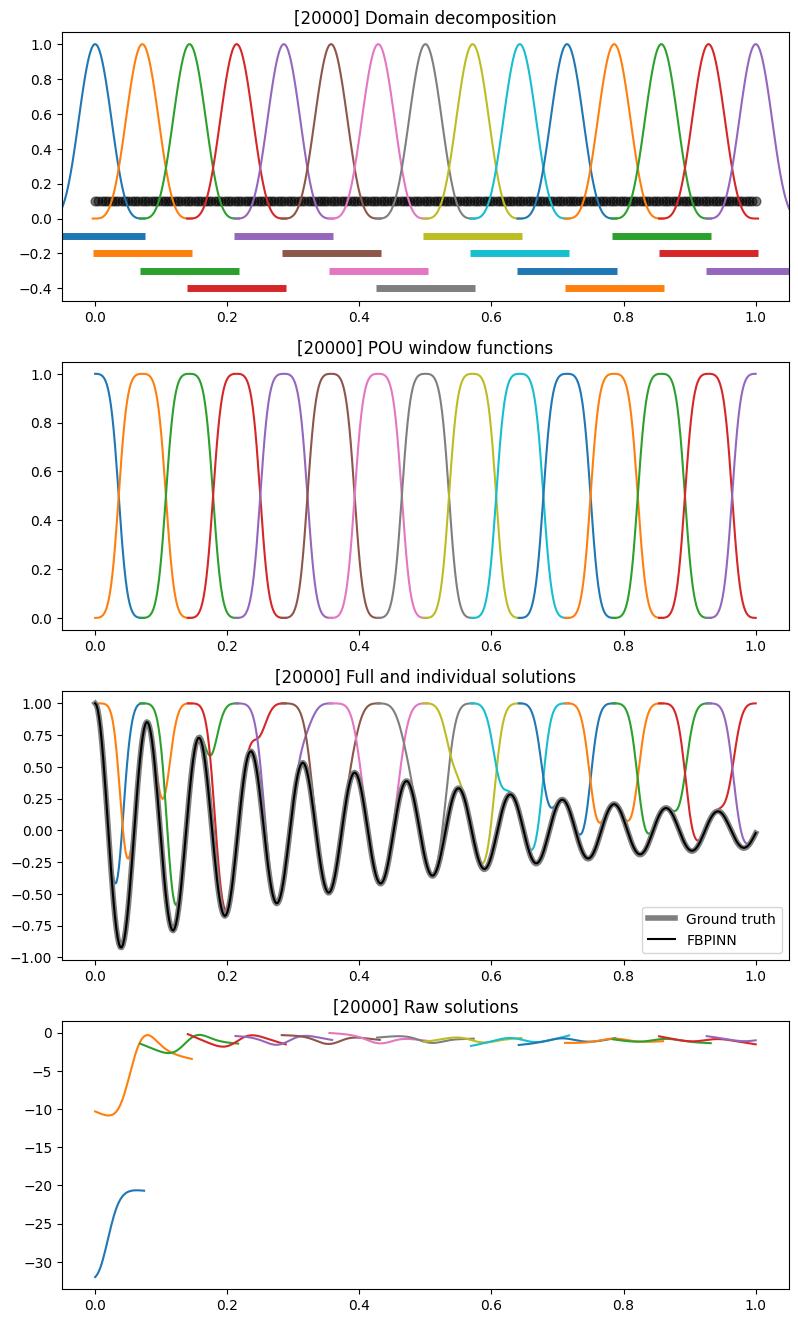

[INFO] 2025-04-18 13:55:06 - [i: 20000/20000] Training complete


In [103]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0,]),
        xmax=np.array([1,]),
    ),
    problem=HarmonicOscillator1DHardBC,
    problem_init_kwargs=dict(
        d=2, w0=80,
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=[np.linspace(0,1,15)],
        subdomain_ws=[0.15*np.ones((15,))],
        unnorm=(0.,1.),
    ),
    network=FCN,
    network_init_kwargs=dict(
        layer_sizes=[1,32,1],
    ),
    ns=((200,),),
    n_test=(500,),
    n_steps=20000,
    clear_output=True,
)

run = FBPINNTrainer(c)
all_params = run.train()

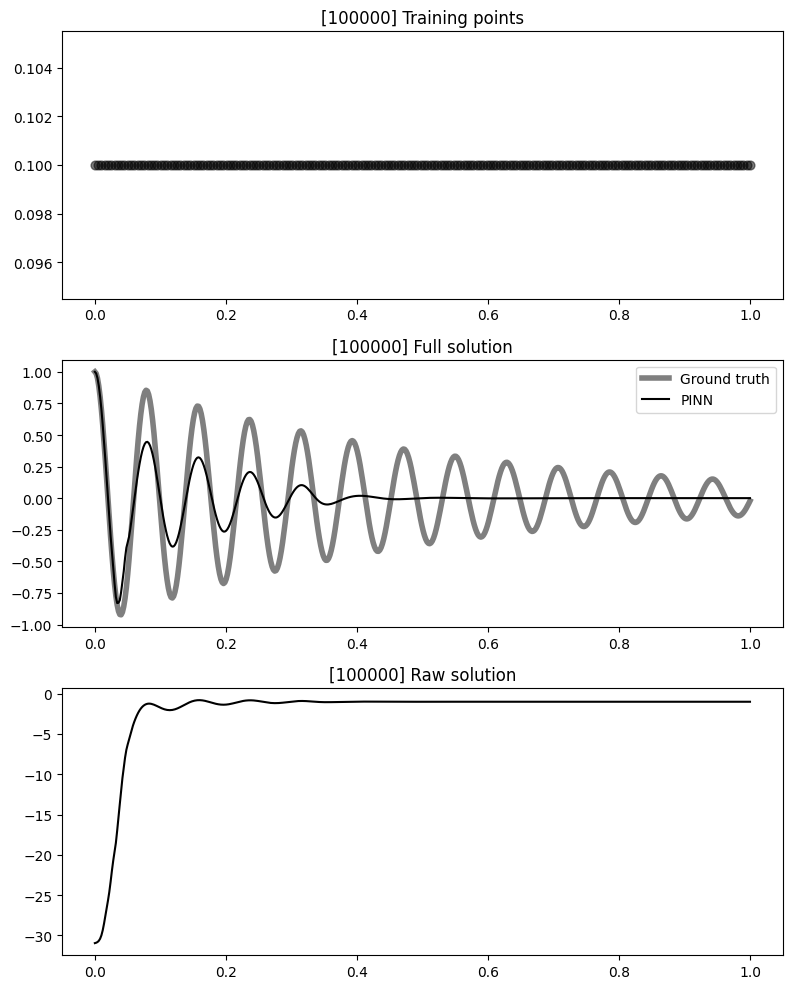

[INFO] 2025-04-18 10:21:12 - [i: 100000/100000] Training complete


{'static': {'domain': {'xd': 1,
   'xmin': Array([0], dtype=int32),
   'xmax': Array([1], dtype=int32)},
  'problem': {'dims': (1, 1),
   'd': 2,
   'w0': 80,
   'mu': 4,
   'k': 6400,
   'sd': 0.1}},
 'trainable': {'network': {'subdomain': {'layers': [(Array([[ 0.35740536],
             [-2.038468  ],
             [ 0.43139383],
             [-1.6308968 ],
             [-1.6023917 ],
             [-0.40347645],
             [ 2.203499  ],
             [ 0.40686655],
             [ 0.0906151 ],
             [ 0.19187494],
             [-0.60958004],
             [ 0.12256534],
             [-2.185831  ],
             [-1.1424146 ],
             [-0.22121617],
             [ 0.06769501],
             [-0.33338812],
             [-0.0689733 ],
             [-0.15313774],
             [-1.8738478 ],
             [ 0.47543794],
             [ 0.53791314],
             [-0.5335846 ],
             [ 2.8308232 ],
             [ 0.08055799],
             [ 0.05377143],
             [ 1.8717048

In [ ]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[1,64,64,1])# use a larger neural network
c["n_steps"] = 100000 # use a larger neural network
run = PINNTrainer(c)
run.train()# start training a PINN on the same problem

# Уравнение Бюргерса


Уравнение в частных производных:

$$
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} = \nu \dfrac{\partial^2 u}{\partial x^2}
$$


In [104]:
import jax.nn
import jax.numpy as jnp
import numpy as np

from fbpinns.util.logger import logger
from fbpinns.traditional_solutions.analytical.burgers_solution import burgers_viscous_time_exact1
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_2D_pressure_second_order import seismicCPML2D


class BurgersEquation2D(Problem):
    """
        du       du        d^2 u
        -- + u * -- = nu * -----
        dt       dx        dx^2

        -1.0 < x < +1.0,  0 < t

        Граничные условия:
        u(x,0) = - sin(pi*x)
        u(-1,t) = u(+1,t) = 0
    """

    @staticmethod
    def init_params(nu=0.01/jnp.pi, sd=0.1):

        static_params = {
            "dims":(1,2),
            "nu":nu,
            "sd":sd,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(1,)),
            (0,(0,0)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh((x+1)/sd)*tanh((1-x)/sd)*tanh((t-0)/sd)*u - sin(pi*x)
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        nu = all_params["static"]["problem"]["nu"]
        _, u, ux, ut, uxx = constraints[0]
        phys = ut + (u*ux) - (nu*uxx)
        return jnp.mean(phys**2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        nu = all_params["static"]["problem"]["nu"]

        xmin,xmax = x_batch[:,0].min().item(), x_batch[:,0].max().item()
        tmin,tmax = x_batch[:,1].min().item(), x_batch[:,1].max().item()
        vx = np.linspace(xmin,xmax,batch_shape[0])
        vt = np.linspace(tmin,tmax,batch_shape[1])
        logger.info("Running burgers_viscous_time_exact1..")
        vu = burgers_viscous_time_exact1(nu, len(vx), vx, len(vt), vt)
        u = jnp.array(vu.flatten()).reshape((-1,1))
        return u


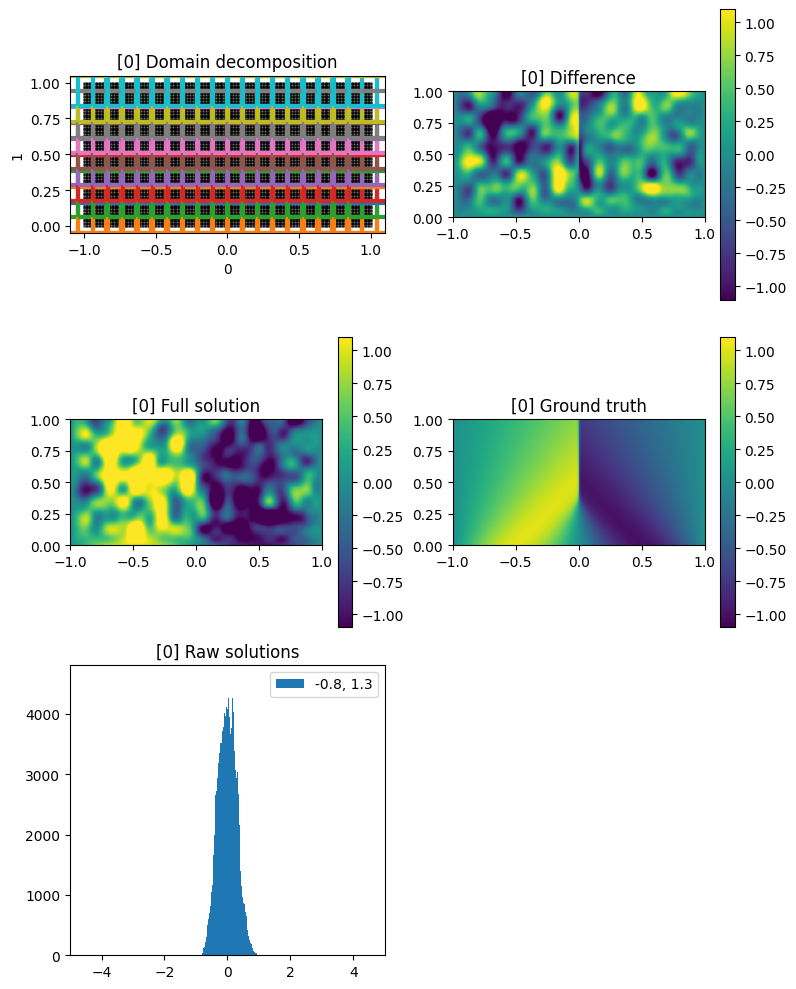

In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

subdomain_xs=[np.linspace(-1,1,20), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([-1,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=BurgersEquation2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    network=FCN,
    network_init_kwargs = dict (
        layer_sizes = (2, 16, 1),
    ),
    ns=((200,100),),
    n_test=(200,100),
    n_steps=100000,
    clear_output=True,
)

run = FBPINNTrainer(c)
all_params = run.train()

<img src="../images/scheduling.gif" width="90%">